## Process ERA5 file Tutorial

This tutorial will walk through processing forecast data from ERA5 using xarray.

Authors:
* Jeffrey Sward (jas983@cornell.edu), Cornell University, February 2020

In [1]:
# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [2]:
# Find the absolute file path to your pvlib installation
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))

# absolute path to ERA data file
era_file1 = os.path.join(optwrf_abspath, '../../../wrf_data/ERA5', 'EastUS_e5.oper.an.sfc.228_246_100u.ll025sc.2011020100_2011022823.nc')
era_file2 = os.path.join(optwrf_abspath, '../../../wrf_data/ERA5', 'EastUS_e5.oper.an.sfc.228_247_100v.ll025sc.2011020100_2011022823.nc')

# Read in the ERA file using the xarray open_dataset method
era_data1 = xr.open_dataset(era_file1)
era_data2 = xr.open_dataset(era_file2)

In [3]:
era_data1.VAR_100U

<xarray.DataArray 'VAR_100U' (time: 672, latitude: 97, longitude: 129)>
[8408736 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * time       (time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
Attributes:
    long_name:                     100 metre U wind component
    short_name:                    100u
    units:                         m s**-1
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             228
    ecmwf_parameter:               246
    minimum_value:                 -47.53589
    maximum_value:                 48.383957
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.0
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.0/
    rda_dataset_doi:               DOI: 10.5065/BH6N-5N20
    rda_dataset_group:             ERA5 atmospheric surface analysis [netCDF4]
    number_of_significant_digits:  7

In [4]:
era_wind_data = xr.merge([era_data1, era_data2])
# era_wind_data

In [5]:
# Calculate the 100m wind speed
wind_speed100 = np.sqrt(era_wind_data['VAR_100U']**2 + era_wind_data['VAR_100V']**2)

# Calculate wind power density (W * m -2)
air_density = 1000 
wpd = 0.5 * air_density * (wind_speed100) ** 3
era_wind_data['WPD'] = wpd
# era_wind_data

In [6]:
era_wind_data = era_wind_data.drop('utc_date')
era_wind_data

<xarray.Dataset>
Dimensions:    (latitude: 97, longitude: 129, time: 672)
Coordinates:
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * time       (time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
Data variables:
    VAR_100U   (time, latitude, longitude) float32 6.0189667 ... -0.84684753
    VAR_100V   (time, latitude, longitude) float32 -3.6479034 ... 0.18159485
    WPD        (time, latitude, longitude) float32 174317.23 ... 324.84235

In [7]:
# Read in the ERA file using the xarray open_dataset method
era_file3 = os.path.join(optwrf_abspath, '../../../wrf_data/ERA5', 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011011606_2011020106.nc')
era_file4 = os.path.join(optwrf_abspath, '../../../wrf_data/ERA5', 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011020106_2011021606.nc')
era_file5 = os.path.join(optwrf_abspath, '../../../wrf_data/ERA5', 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011021606_2011030106.nc')

try:
    era_data3 = xr.open_dataset(era_file3)
    era_data4 = xr.open_dataset(era_file4)
    era_data5 = xr.open_dataset(era_file5)
except FileNotFoundError as e:
    # Download the ERA file containing surface solar radiation downward (ssrd)
    filelist = ['e5.oper.fc.sfc.accumu/201012/e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011011606_2011020106.nc', 
    'e5.oper.fc.sfc.accumu/201101/e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011020106_2011021606.nc', 
    'e5.oper.fc.sfc.accumu/201101/e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011021606_2011030106.nc']
    dspath = 'http://rda.ucar.edu/data/ds633.0/'
    runwrf.rda_download(filelist, dspath)
    # Use NCO tools to extract the Northeast region (only works if NCO is installed)
    CMD_REDUCE = 'ncks -d longitude,264.,296. -d latitude,28.,52. %s %s'
    os.system(CMD_REDUCE % ('e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011011606_2011020106.nc', 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011011606_2011020106.nc'))
    os.system(CMD_REDUCE % ('e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011020106_2011021606.nc', 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011020106_2011021606.nc'))
    os.system(CMD_REDUCE % ('e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011021606_2011030106.nc', 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011021606_2011030106.nc'))
    # Move the files into the expected directory 
    os.rename(os.path.join(os.getcwd(), 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011011606_2011020106.nc'), era_file3)
    os.rename(os.path.join(os.getcwd(), 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011020106_2011021606.nc'), era_file4)
    os.rename(os.path.join(os.getcwd(), 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011021606_2011030106.nc'), era_file5)
    # Open the ERA files
    era_data3 = xr.open_dataset(era_file3)
    era_data4 = xr.open_dataset(era_file4)
    era_data5 = xr.open_dataset(era_file5)


In [8]:
era_ssrd_data = xr.concat([era_data3, era_data4, era_data5], 'forecast_initial_time')
era_ssrd_data

<xarray.Dataset>
Dimensions:                (forecast_hour: 12, forecast_initial_time: 88, latitude: 97, longitude: 129)
Coordinates:
  * forecast_hour          (forecast_hour) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude               (latitude) float64 52.0 51.75 51.5 ... 28.25 28.0
  * longitude              (longitude) float64 264.0 264.2 264.5 ... 295.8 296.0
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 2011-01-16T...
Data variables:
    SSRD                   (forecast_initial_time, forecast_hour, latitude, longitude) float32 ...
    utc_date               (forecast_initial_time) int32 2011011606 ... 20110...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 19:24:29 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Aug 14 16:39:52 2020: ncks -d longitude,264.,29...
    NCO:                  netCDF Operators version 4.8.1 (Homepage = http://n...

In [9]:
# Initialize a new dataset
era_ssrd_proc = era_ssrd_data.drop_dims(['forecast_initial_time', 'forecast_hour'])
# era_ssrd_proc

In [10]:
# Extract SSRD from a single forecast
idx = 0
timestr = era_ssrd_data.forecast_initial_time[idx]
ssrd_slice = era_ssrd_data.sel(forecast_initial_time=timestr)
# ssrd_slice

In [11]:
# Make the forecast_hour coordinate type=datetime64
ssrd_slice = ssrd_slice.assign_coords(forecast_hour=pd.date_range(start=timestr.values, freq='H', 
                                            periods=(len(era_ssrd_data.forecast_hour))))
# ssrd_slice

In [12]:
# Rename the forecast_hour dimension
ssrd_slice = ssrd_slice.rename({'forecast_hour' : 'time'})
# ssrd_slice

In [13]:
# Drop the forecast_initial_time coordinate
ssrd_slice = ssrd_slice.reset_coords('forecast_initial_time', drop=True)
# ssrd_slice

In [14]:
# Add the ssrd_slice back into the era_proc dataset
if idx is 0:
    era_ssrd_proc['SSRD'] = ssrd_slice['SSRD']
else:
    era_ssrd_proc = xr.concat([era_ssrd_proc, ssrd_slice], dim='time')
era_ssrd_proc

<xarray.Dataset>
Dimensions:    (latitude: 97, longitude: 129, time: 12)
Coordinates:
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * time       (time) datetime64[ns] 2011-01-16T06:00:00 ... 2011-01-16T17:00:00
Data variables:
    SSRD       (time, latitude, longitude) float32 0.0 0.0 ... 931072.0 888832.0
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 19:24:29 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Aug 14 16:39:52 2020: ncks -d longitude,264.,29...
    NCO:                  netCDF Operators version 4.8.1 (Homepage = http://n...

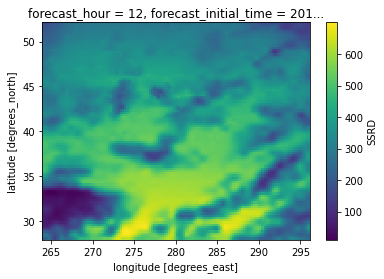

In [15]:
# Test visualization plot from initial dataset
ssrd = era_data3.SSRD.sel(forecast_initial_time='2011-01-16 06:00:00',forecast_hour=12)
ghi = ssrd/3600
ghi.plot()

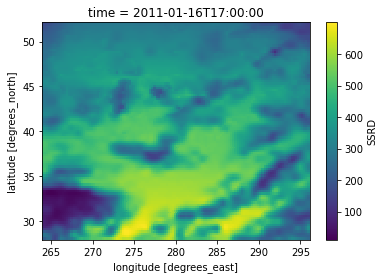

In [16]:
# Test visualization plot from processed dataset (should be the same as above)
tidx = 17
timestr = f'2011-01-16 {tidx}:00:00'
ssrd = era_ssrd_proc.SSRD.sel(time=timestr)
ghi = ssrd/3600
ghi.plot()

In [17]:
# Now actually process the whole dataset
era_ssrd_processed = era_ssrd_data.drop_dims(['forecast_initial_time', 'forecast_hour'])

first = True
for timestr in era_ssrd_data.forecast_initial_time:
    ssrd_slice = era_ssrd_data.sel(forecast_initial_time=timestr)
    ssrd_slice = ssrd_slice.assign_coords(forecast_hour=pd.date_range(start=timestr.values, freq='H', 
                                            periods=(len(ssrd_slice.forecast_hour))))
    ssrd_slice = ssrd_slice.rename({'forecast_hour' : 'time'})
    ssrd_slice = ssrd_slice.reset_coords('forecast_initial_time', drop=True)
    if first is True:
        era_ssrd_processed['SSRD'] = ssrd_slice['SSRD']
        first = False
    else:
        era_ssrd_processed = xr.concat([era_ssrd_processed, ssrd_slice], 'time')

era_ssrd_processed

<xarray.Dataset>
Dimensions:    (latitude: 97, longitude: 129, time: 1056)
Coordinates:
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * time       (time) datetime64[ns] 2011-01-16T06:00:00 ... 2011-03-01T05:00:00
Data variables:
    utc_date   (time) int32 2011011618 2011011618 ... 2011022818 2011022818
    SSRD       (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 19:24:29 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Aug 14 16:39:52 2020: ncks -d longitude,264.,29...
    NCO:                  netCDF Operators version 4.8.1 (Homepage = http://n...

In [18]:
# Convert SSRD to GHI
ghi = era_ssrd_processed.SSRD/3600
era_ssrd_processed['GHI'] = ghi
# era_ssrd_processed

In [19]:
era_ssrd_processed = era_ssrd_processed.drop('utc_date')
era_ssrd_processed

<xarray.Dataset>
Dimensions:    (latitude: 97, longitude: 129, time: 1056)
Coordinates:
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * time       (time) datetime64[ns] 2011-01-16T06:00:00 ... 2011-03-01T05:00:00
Data variables:
    SSRD       (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    GHI        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 19:24:29 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Aug 14 16:39:52 2020: ncks -d longitude,264.,29...
    NCO:                  netCDF Operators version 4.8.1 (Homepage = http://n...

In [20]:
# Combine the wind power density and ghi datasets
era_out = xr.merge([era_wind_data, era_ssrd_processed])
era_out

<xarray.Dataset>
Dimensions:    (latitude: 97, longitude: 129, time: 1056)
Coordinates:
  * time       (time) datetime64[ns] 2011-01-16T06:00:00 ... 2011-03-01T05:00:00
  * latitude   (latitude) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
  * longitude  (longitude) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
Data variables:
    VAR_100U   (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    VAR_100V   (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    WPD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    SSRD       (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    GHI        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [21]:
# Slice the dataset to only one month (UTC)
era_out.sel(time=slice('2011-02-01 00:00:00', '2011-02-28 23:00:00'))
# Rename the time dimension to be consistent with wrfout.nc
era_out = era_out.rename({'time' : 'Time'})

In [22]:
# Write the processed data back to a wrfout NetCDF file
new_file = './ERA5_EastUS_WPD-GHI_2011-02.nc'
era_out.to_netcdf(path=new_file)